In [1]:
import os
import pandas as pd


def parse_tracker_info(info_string):
    components = info_string.split('__')
    tracker_name = components[0]
    resolution = components[1].split('_')[1]
    confidence_input = components[2].split('_')[1]
    yolo_model_type = components[3].split('_')[1]

    return {
        "tracker": tracker_name,
        "resolution": resolution,
        "conf": confidence_input,
        "model": yolo_model_type
    }

# Function to extract data from a given path
def extract_data(path, dataset):
    data = []
    files = os.listdir(path)

    for file in files:
        # Parse the file name to get the tracker information
        info = parse_tracker_info(file)
        
        # Path to the pedestrian summary file
        summary_path = os.path.join(path, file, "pedestrian_summary.txt")
        
        # Check if the pedestrian summary file exists
        if os.path.exists(summary_path):
            try:
                # Read pedestrian summary file
                results = pd.read_csv(summary_path, sep=' ')
                # Append the extracted data as a dictionary
                data.append({
                    "dataset": dataset,
                    "tracker": info["tracker"],
                    "resolution": info["resolution"],
                    "conf": info["conf"],
                    "model": info["model"],
                    "HOTA": results['HOTA'][0],
                    "AssA": results['AssA'][0],
                    "AssRe" : results['AssRe'][0],
                    "AssPr" : results['AssPr'][0],
                    "LocA" : results['LocA'][0],
                    "DetA" : results['DetA'][0],
                    "Dets" : results['Dets'][0],
                })
            except Exception as e:
                print(f"Error processing file {summary_path}: {e}")
    return data

# Paths to the directories
path_17 = '/media/hbai/data/LITE/results/yolo_exp/MOT17-train'
path_20 = '/media/hbai/data/LITE/results/yolo_exp/MOT20-train'


# Extract data from both paths
data_17 = extract_data(path_17, "MOT17")
data_20 = extract_data(path_20, "MOT20")

# Combine the data into a single DataFrame
all_data = pd.DataFrame(data_17 + data_20)
all_data

,dataset,tracker,resolution,conf,model,HOTA,AssA,AssRe,AssPr,LocA,DetA,Dets
0,MOT17,LITEStrongSORT,1280,0.4,yolov8l,43.1010,47.151,54.239,72.460,84.023,39.6940,62714
1,MOT17,LITEStrongSORT,1280,0.65,yolov8m,39.5580,47.128,54.356,72.823,85.018,33.3210,48848
2,MOT17,LITEStrongSORT,1280,0.35,yolov8n,39.8440,40.205,48.378,63.420,82.705,39.9730,65687
3,MOT17,LITEStrongSORT,1280,0.55,yolov8n,38.1170,43.217,51.170,68.720,84.229,33.8540,49690
4,MOT17,LITEStrongSORT,1280,0.1,yolov8s,38.6970,38.759,46.965,59.694,80.148,39.7420,126830
...,...,...,...,...,...,...,...,...,...,...,...,...
145,MOT20,LITEStrongSORT,1280,0.7,yolov8l,10.6950,24.331,27.175,67.257,82.907,4.7463,67364
146,MOT20,LITEStrongSORT,1280,0.45,yolov8m,19.0740,25.755,29.456,60.330,79.792,14.2650,221126
147,MOT20,LITEStrongSORT,1280,0.45,yolov8x,15.2350,24.867,28.520,62.501,80.982,9.4279,141943
148,MOT20,LITEStrongSORT,1280,0.3,yolov8x,20.0210,26.504,30.405,59.664,79.764,15.2790,239625


In [2]:
model_order = ["yolov8n","yolov8s","yolov8m", "yolov8l", "yolov8x"]

# Convert model to a categorical type with the specified order
all_data["model"] = pd.Categorical(all_data["model"], categories=model_order, ordered=True)

# Sort the data by dataset, model, and confidence threshold
all_data = all_data.sort_values(by=["conf"])

In [3]:
all_data['Dets'] = all_data['Dets']/1000 

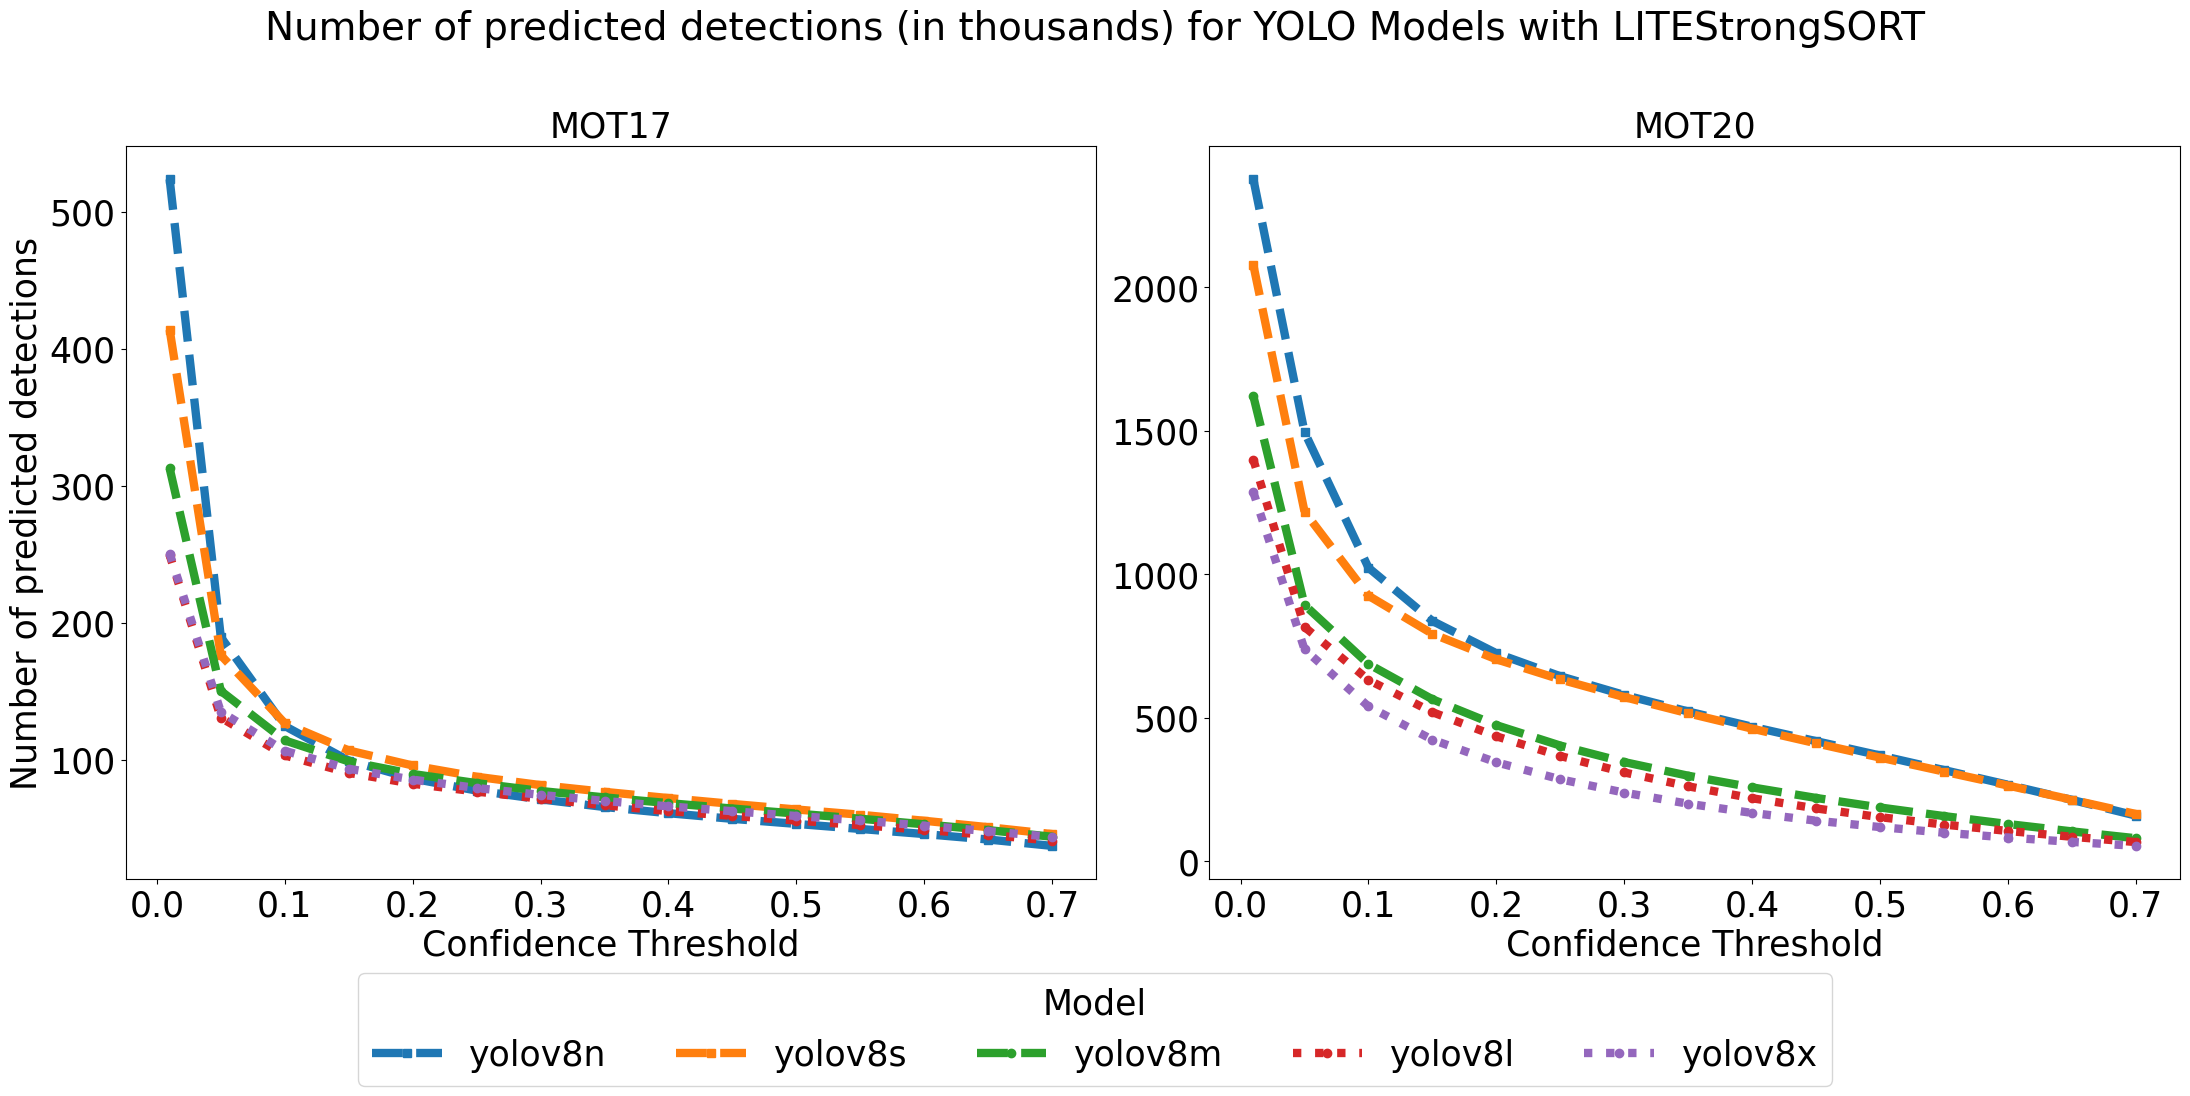

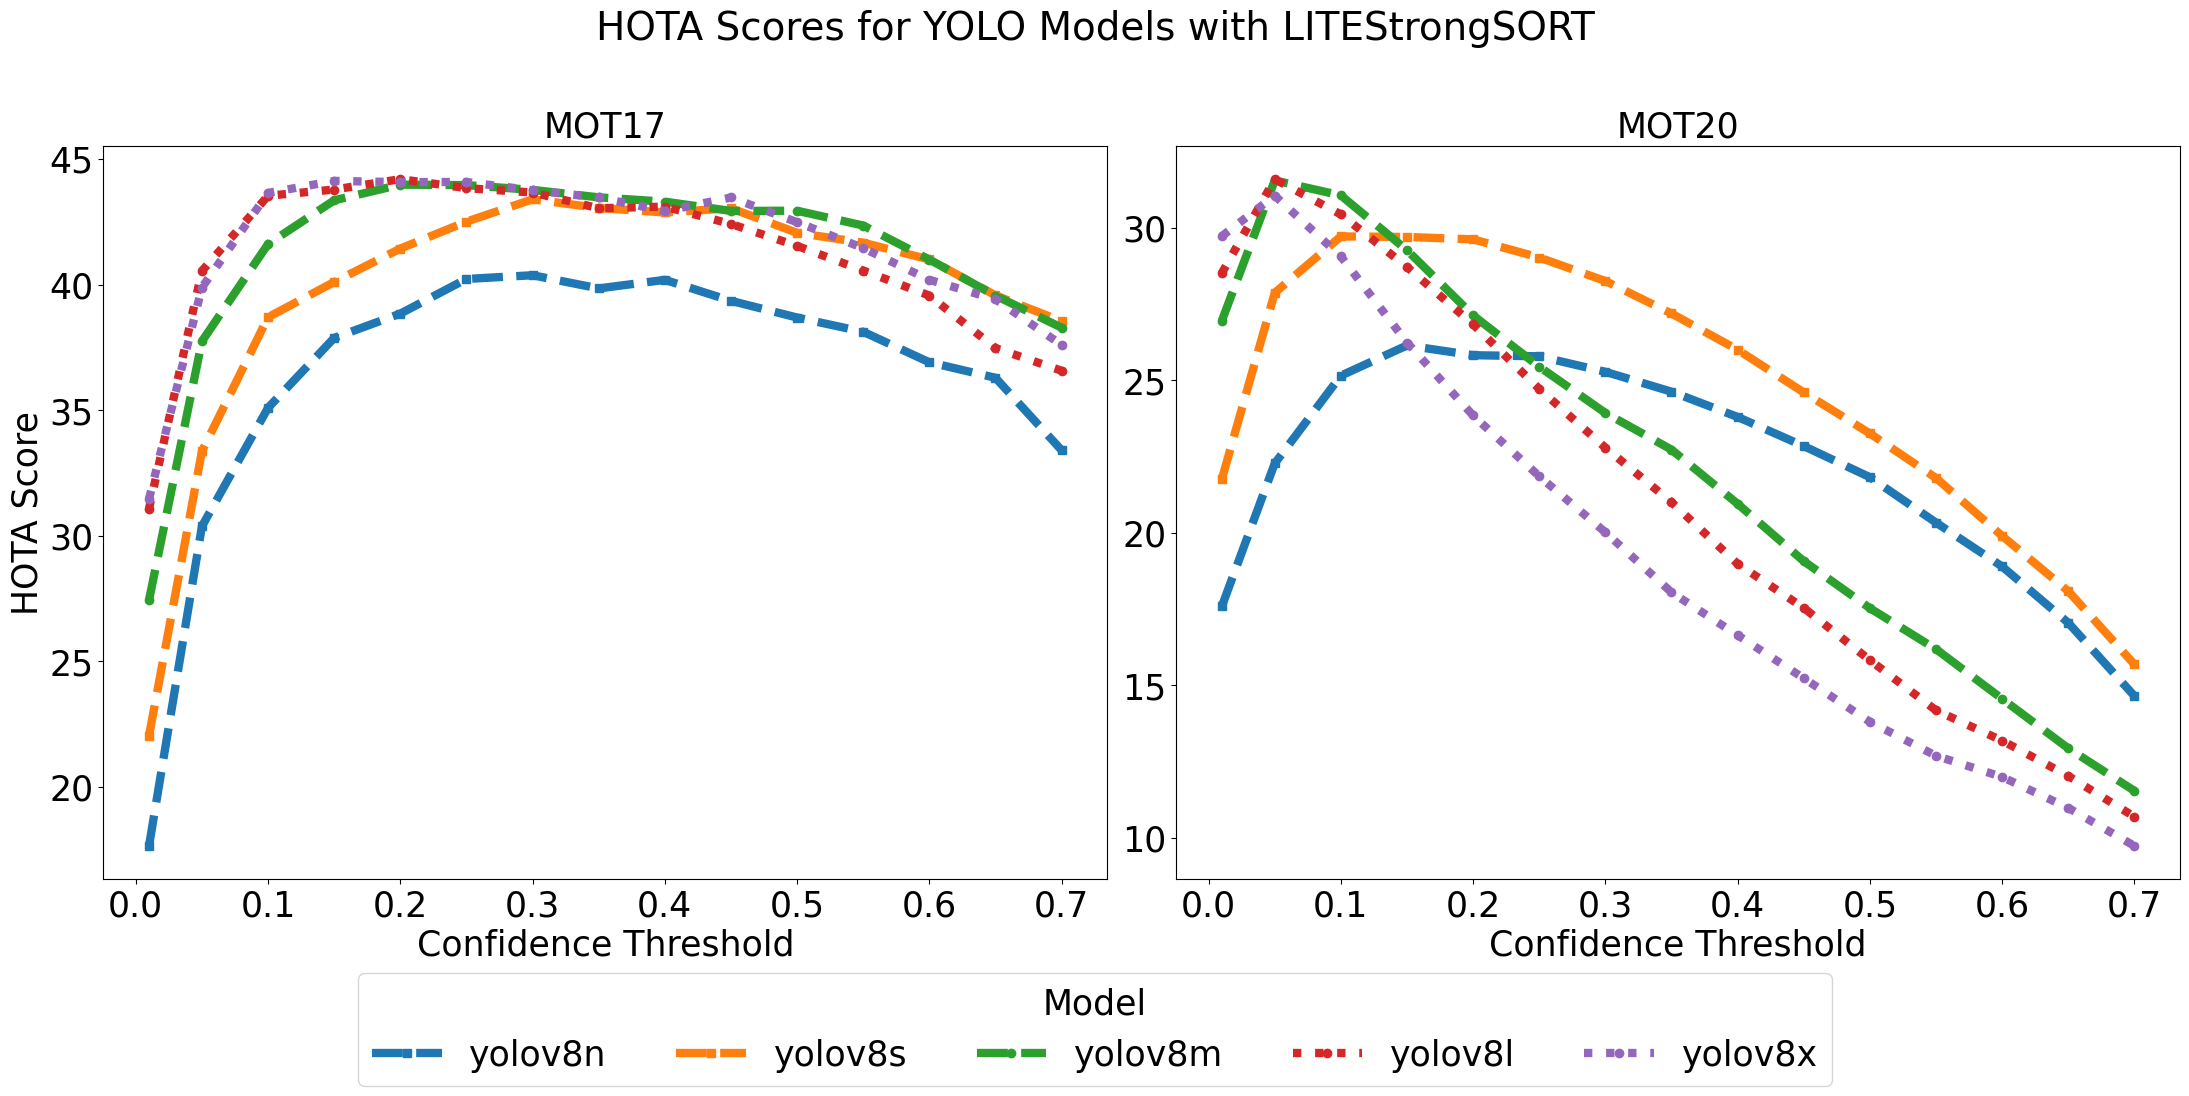

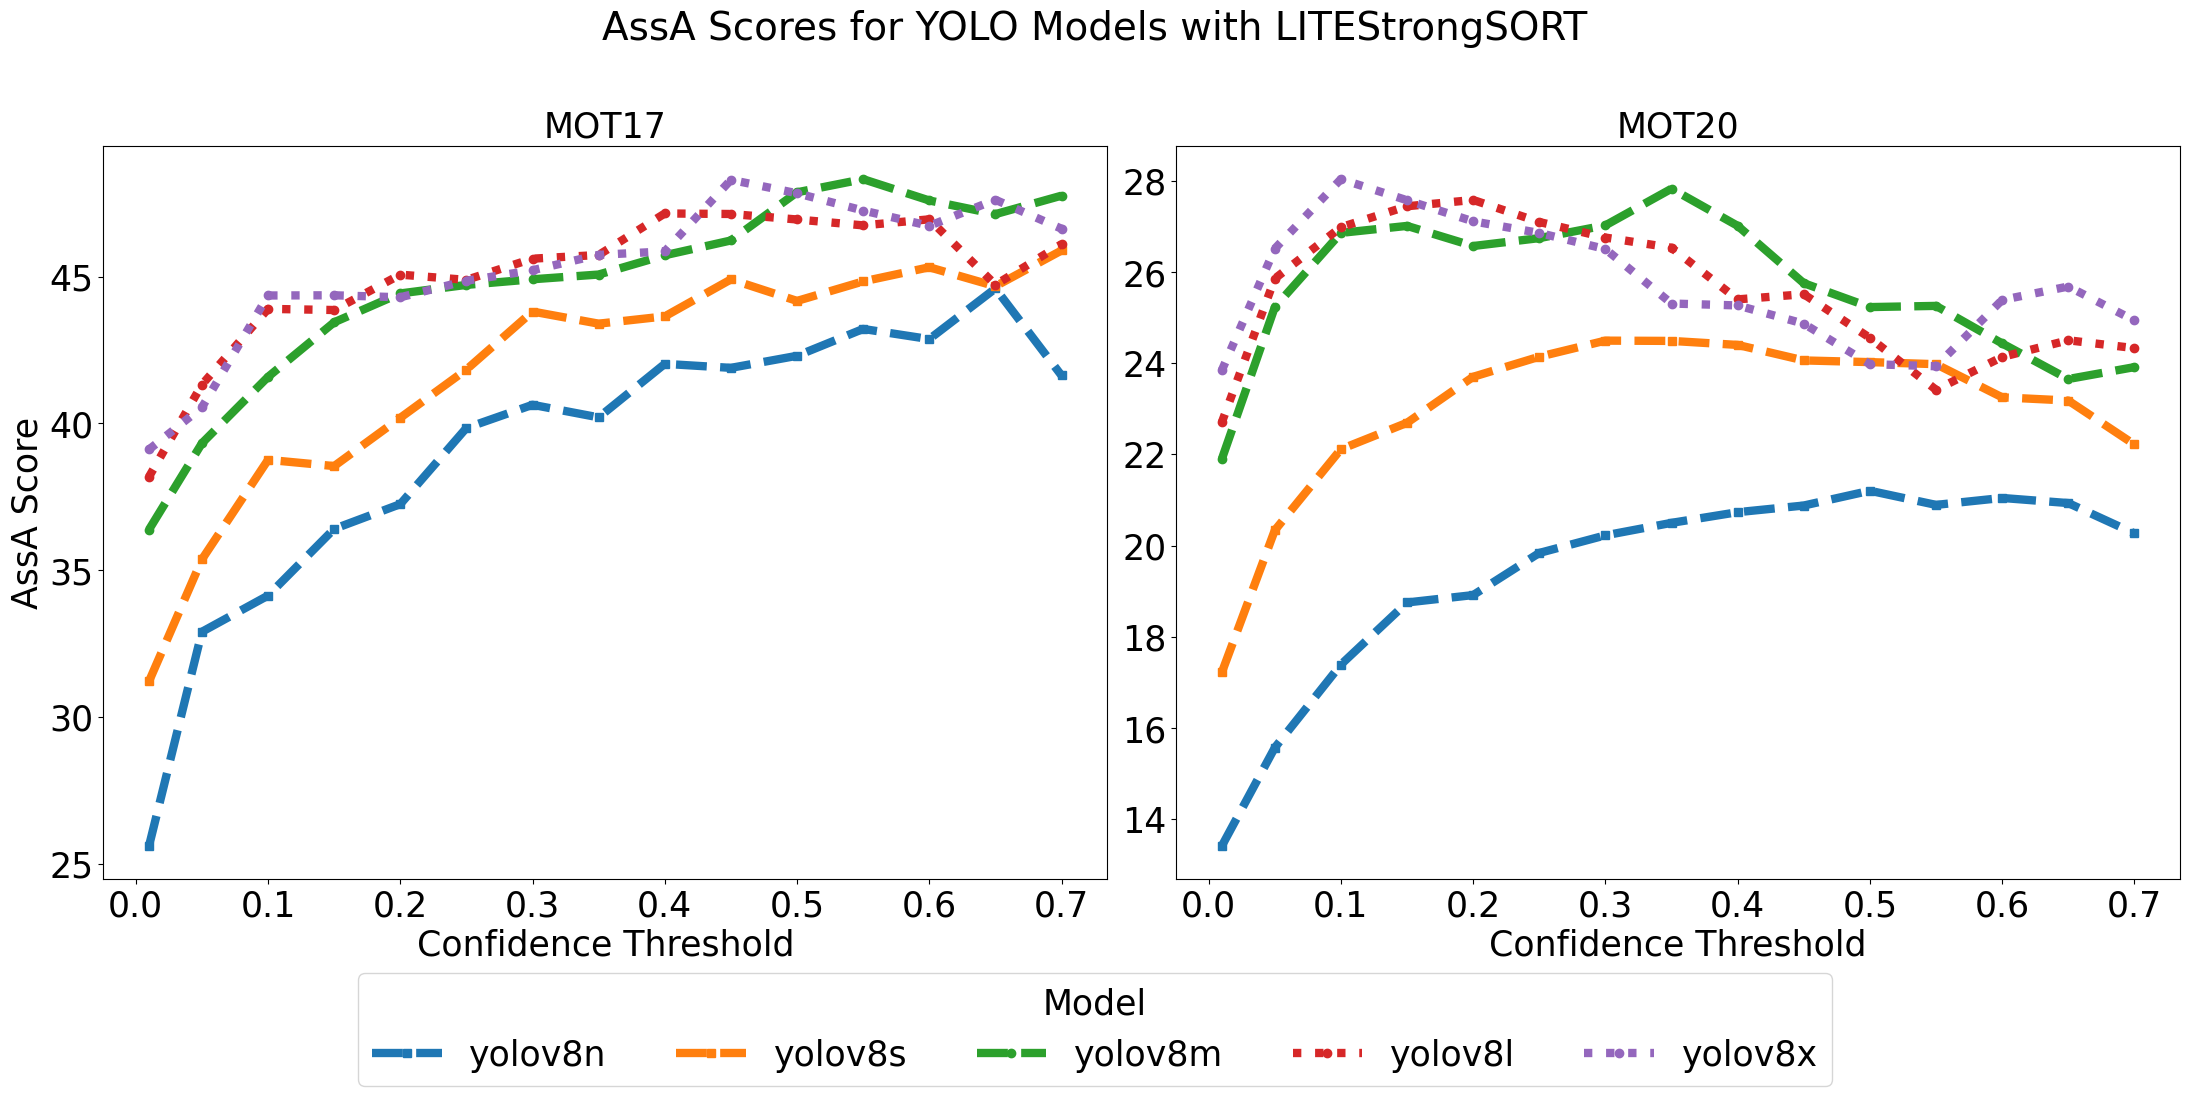

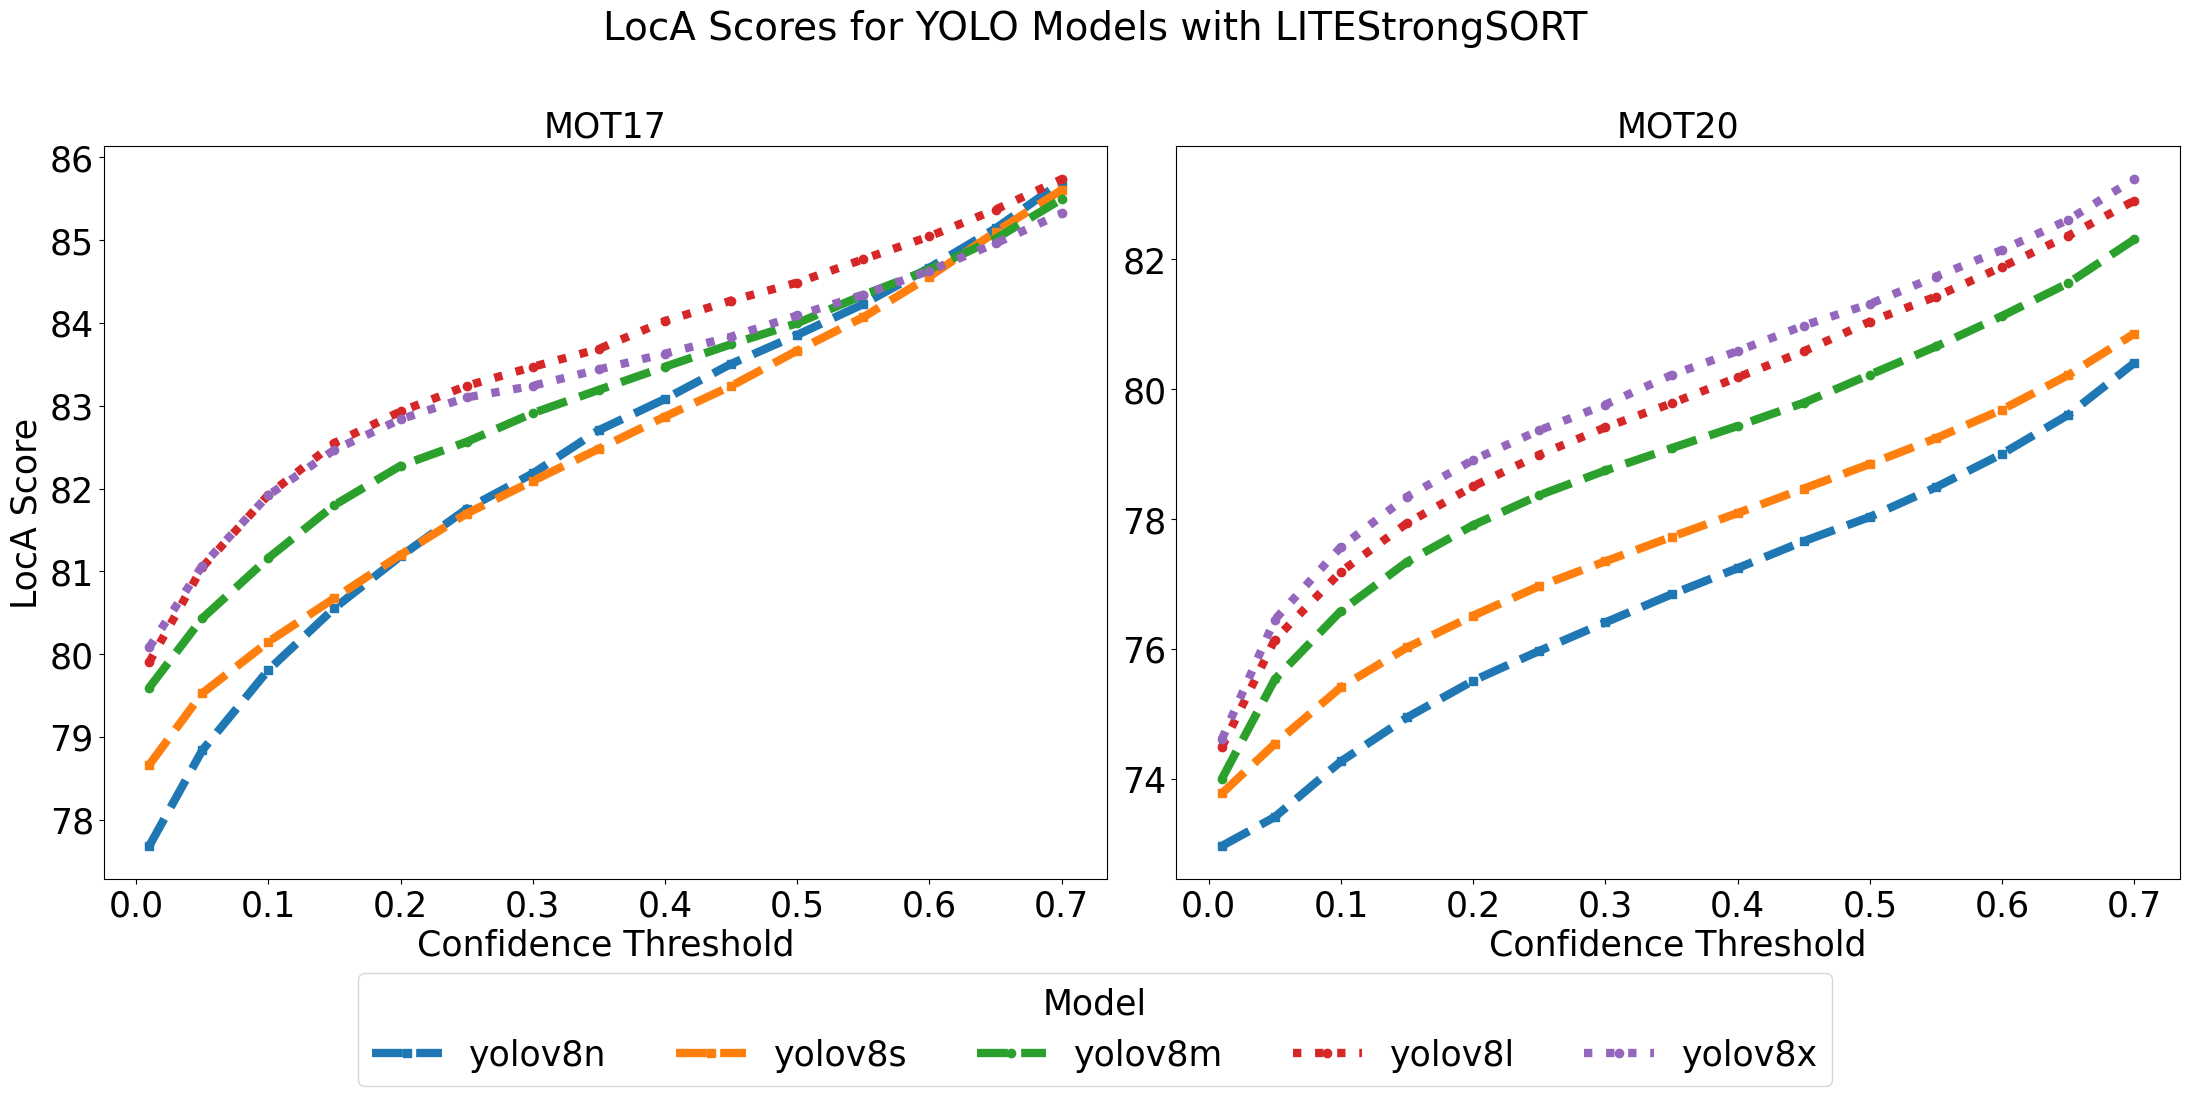

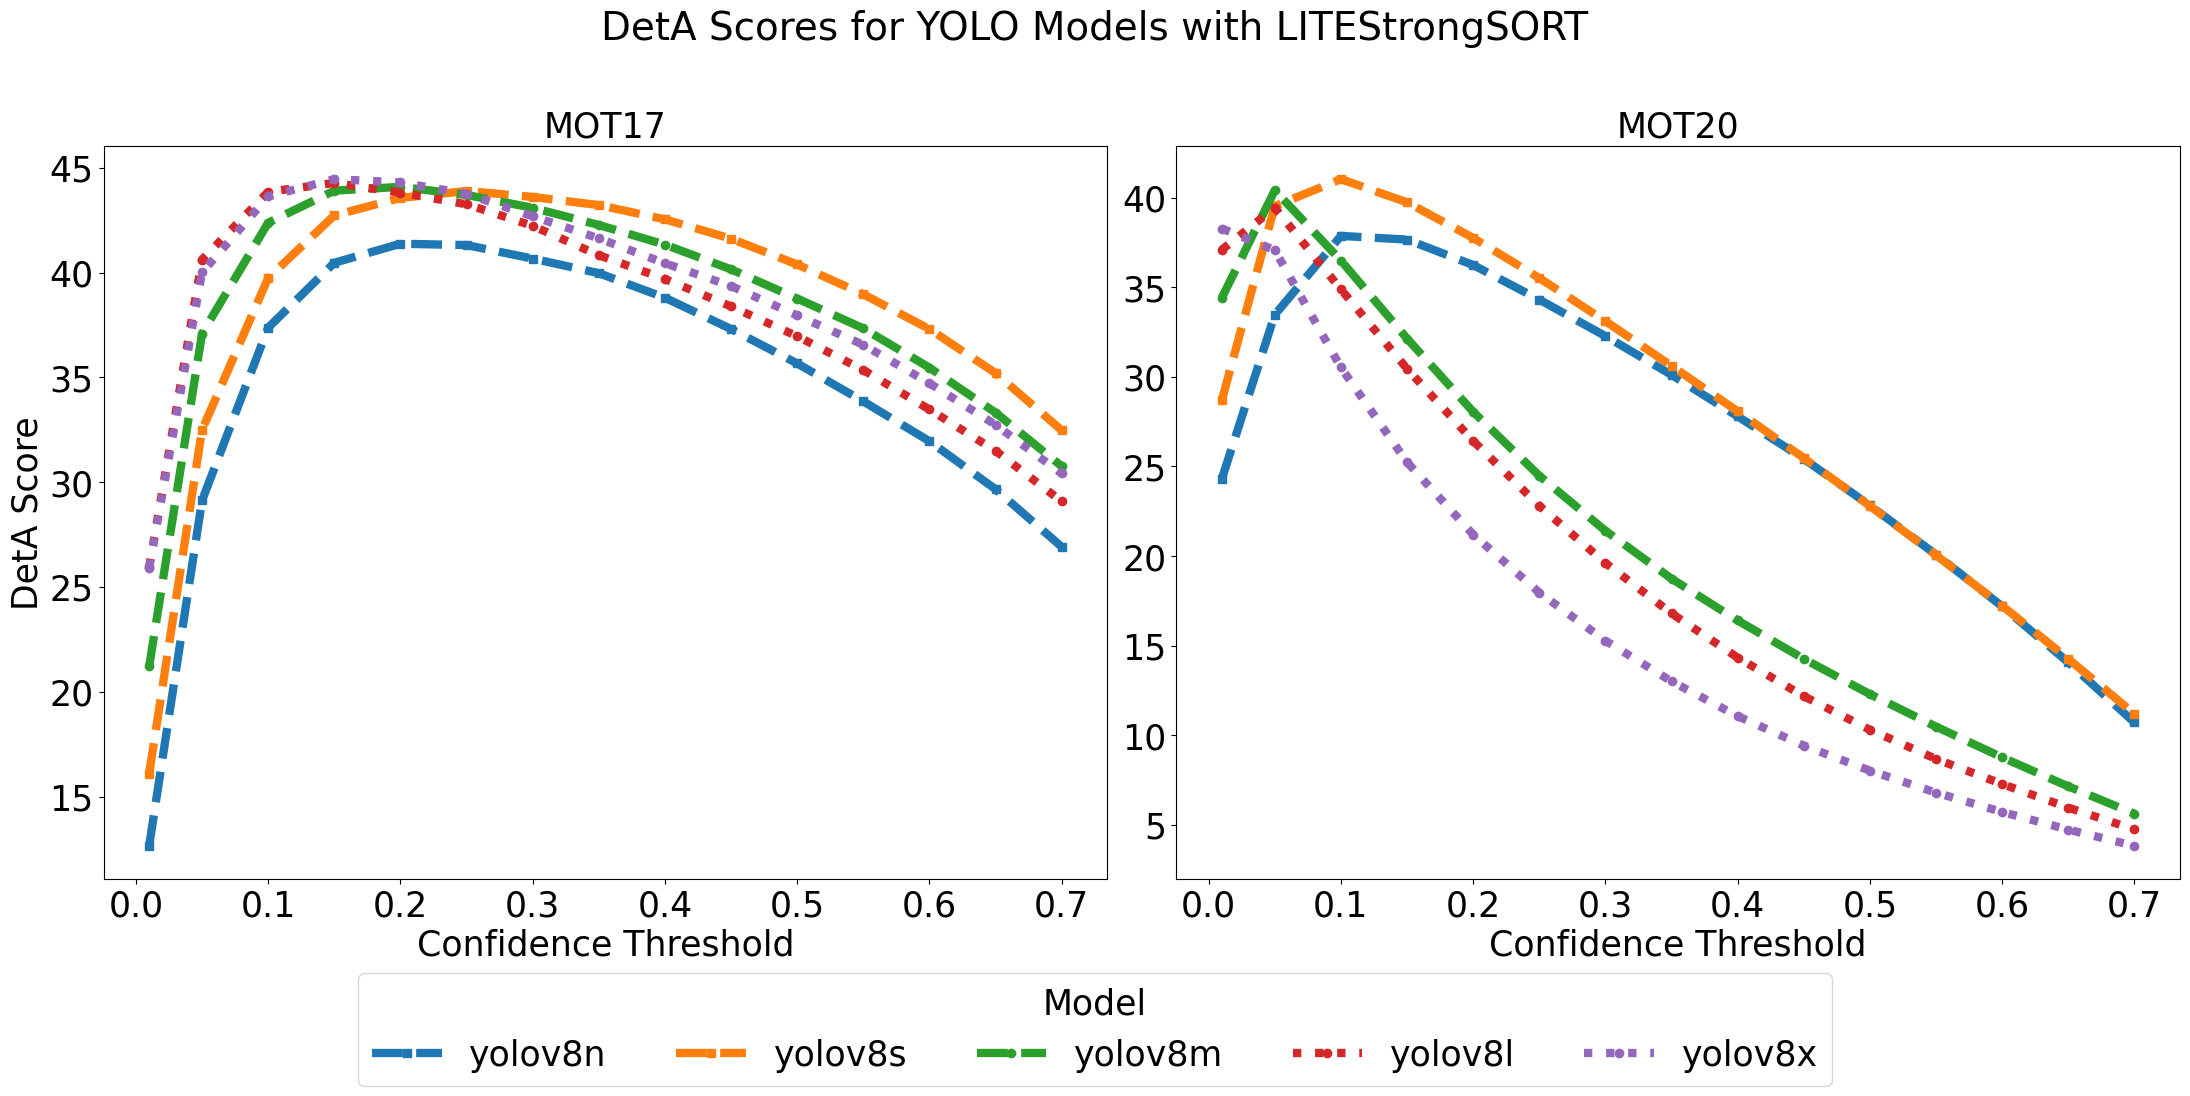

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming `all_data` is already defined with combined MOT17 and MOT20 data

# List of metrics to plot
metrics = ["Dets", "HOTA", "AssA", "LocA", "DetA"]

# List of distinct trackers
trackers = ["yolov8n", "yolov8s", "yolov8m", "yolov8l", "yolov8x"]
# Assign unique markers and line styles for each tracker
markers = ['s', 's', 'o', 'o', 'o']  # Fixed set of markers
line_styles = ['--', '--', '--', ':', ':']  # Fixed set of line styles

# Create a color map for each tracker
color_map = {i: plt.cm.tab10(i) for i in range(len(trackers))}

# Generate plots for each metric
for metric in metrics:
    # Group data by dataset, model, and confidence threshold for the current metric
    curve_data = all_data.groupby(["dataset", "model", "conf"], observed=False)[metric].mean().reset_index()

    # Create subplots for each dataset
    fig, axs = plt.subplots(1, 2, figsize=(22, 11))

    # Dataset names
    datasets = curve_data["dataset"].unique()

    # Iterate through datasets and plot on respective subplot
    for idx, dataset in enumerate(datasets):
        ax = axs[idx]
        dataset_data = curve_data[curve_data["dataset"] == dataset]
        for i, model in enumerate(dataset_data["model"].unique()):
            model_data = dataset_data[dataset_data["model"] == model]
            ax.plot(
                model_data["conf"].astype(float),
                model_data[metric],
                marker=markers[i],
                linestyle=line_styles[i],
                label=f"{model}",
                color=color_map[i],
                linewidth=6
            )
        # Add subplot details
        ax.set_title(f"{dataset}", fontsize=25)
        ax.set_xlabel("Confidence Threshold", fontsize=25)
        if idx == 0:  # Add ylabel only on the left subplot
            ax.set_ylabel(f"{metric} Score", fontsize=25)
            if metric == 'Dets':
                ax.set_ylabel("Number of predicted detections", fontsize=25)                
        ax.set_xticks(np.linspace(0, 0.7, 8))
        ax.tick_params(axis='both', labelsize=25)

    # Create a single legend for the bottom
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(
        handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.12), ncol=5, fontsize=25, title="Model", title_fontsize=25
    )

    # Adjust layout and save
    fig.suptitle(f"{metric} Scores for YOLO Models with LITEStrongSORT", fontsize=28)
    if metric == 'Dets':
             fig.suptitle(f"Number of predicted detections (in thousands) for YOLO Models with LITEStrongSORT", fontsize=28)
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    plt.savefig(f"{metric.lower()}_v8.png", dpi=600)
    plt.show()

In [5]:
import os
import pandas as pd


def parse_tracker_info(info_string):
    components = info_string.split('__')
    tracker_name = components[0]
    resolution = components[1].split('_')[1]
    confidence_input = components[2].split('_')[1]
    yolo_model_type = components[3].split('_')[1]

    return {
        "tracker": tracker_name,
        "resolution": resolution,
        "conf": confidence_input,
        "model": yolo_model_type
    }


# Function to extract data from a given path
def extract_data(path, dataset):
    data = []
    files = os.listdir(path)

    for file in files:
        # Parse the file name to get the tracker information
        info = parse_tracker_info(file)
        
        # Path to the pedestrian summary file
        summary_path = os.path.join(path, file, "pedestrian_detailed.csv")
        
        if os.path.exists(summary_path):
            # Read the CSV file
            df = pd.read_csv(summary_path)
            
            # Extract `CLR_FP` for the video
            for _, row in df.iterrows():
                data.append({
                    "dataset": dataset,
                    "video": row.get("seq", "unknown"),  # 'seq' is assumed to hold video names
                    "tracker": info["tracker"],
                    "resolution": info["resolution"],
                    "conf": info["conf"],
                    "model": info["model"],
                    "clr_fp": row.get("CLR_FP"),  # Get CLR_FP column, default to 0 if missing
                    "clr_fn": row.get('CLR_FN'),
                    "clr_tp": row.get('CLR_TP'),
                    "clr_tn": row.get('CLR_TN'),
                    
                })
    return data


# Paths to the directories
path_17 = '/media/hbai/data/LITE/results/yolo_exp/MOT17-train'
path_20 = '/media/hbai/data/LITE/results/yolo_exp/MOT20-train'

# Extract data from both paths
data_17 = pd.DataFrame(extract_data(path_17, "MOT17"))
data_20 = pd.DataFrame(extract_data(path_20, "MOT20"))

# Combine the data into a single DataFrame
all_data = pd.concat([data_17 , data_20])

# Display the combined data
all_data

,dataset,video,tracker,resolution,conf,model,clr_fp,clr_fn,clr_tp,clr_tn
0,MOT17,MOT17-02-FRCNN,LITEStrongSORT,1280,0.4,yolov8l,367,12282,6299,None
1,MOT17,MOT17-04-FRCNN,LITEStrongSORT,1280,0.4,yolov8l,1863,27004,20553,None
2,MOT17,MOT17-05-FRCNN,LITEStrongSORT,1280,0.4,yolov8l,1393,2646,4271,None
3,MOT17,MOT17-09-FRCNN,LITEStrongSORT,1280,0.4,yolov8l,524,1333,3992,None
4,MOT17,MOT17-10-FRCNN,LITEStrongSORT,1280,0.4,yolov8l,1162,4806,8033,None
...,...,...,...,...,...,...,...,...,...,...
370,MOT20,MOT20-01,LITEStrongSORT,1280,0.7,yolov8x,61,14797,5073,None
371,MOT20,MOT20-02,LITEStrongSORT,1280,0.7,yolov8x,1087,123981,30761,None
372,MOT20,MOT20-03,LITEStrongSORT,1280,0.7,yolov8x,107,299196,14462,None
373,MOT20,MOT20-05,LITEStrongSORT,1280,0.7,yolov8x,2,643769,2575,None


In [6]:
model_order = ["yolov8n", "yolov8s", "yolov8m", "yolov8l", "yolov8x"]

# Convert model to a categorical type with the specified order
data_20["model"] = pd.Categorical(data_20["model"], categories=model_order, ordered=True)

# Sort the data by dataset, model, and confidence threshold
data_20 = data_20.sort_values(by=["dataset", "model", "conf"])

In [7]:
data_20

,dataset,video,tracker,resolution,conf,model,clr_fp,clr_fn,clr_tp,clr_tn
160,MOT20,MOT20-01,LITEStrongSORT,1280,0.01,yolov8n,49585,3756,16114,None
161,MOT20,MOT20-02,LITEStrongSORT,1280,0.01,yolov8n,295457,34527,120215,None
162,MOT20,MOT20-03,LITEStrongSORT,1280,0.01,yolov8n,532904,54020,259638,None
163,MOT20,MOT20-05,LITEStrongSORT,1280,0.01,yolov8n,625268,168841,477503,None
164,MOT20,COMBINED,LITEStrongSORT,1280,0.01,yolov8n,1503214,261144,873470,None
...,...,...,...,...,...,...,...,...,...,...
370,MOT20,MOT20-01,LITEStrongSORT,1280,0.7,yolov8x,61,14797,5073,None
371,MOT20,MOT20-02,LITEStrongSORT,1280,0.7,yolov8x,1087,123981,30761,None
372,MOT20,MOT20-03,LITEStrongSORT,1280,0.7,yolov8x,107,299196,14462,None
373,MOT20,MOT20-05,LITEStrongSORT,1280,0.7,yolov8x,2,643769,2575,None


In [8]:
data_20['clr_fn'] = data_20['clr_fn']/1000

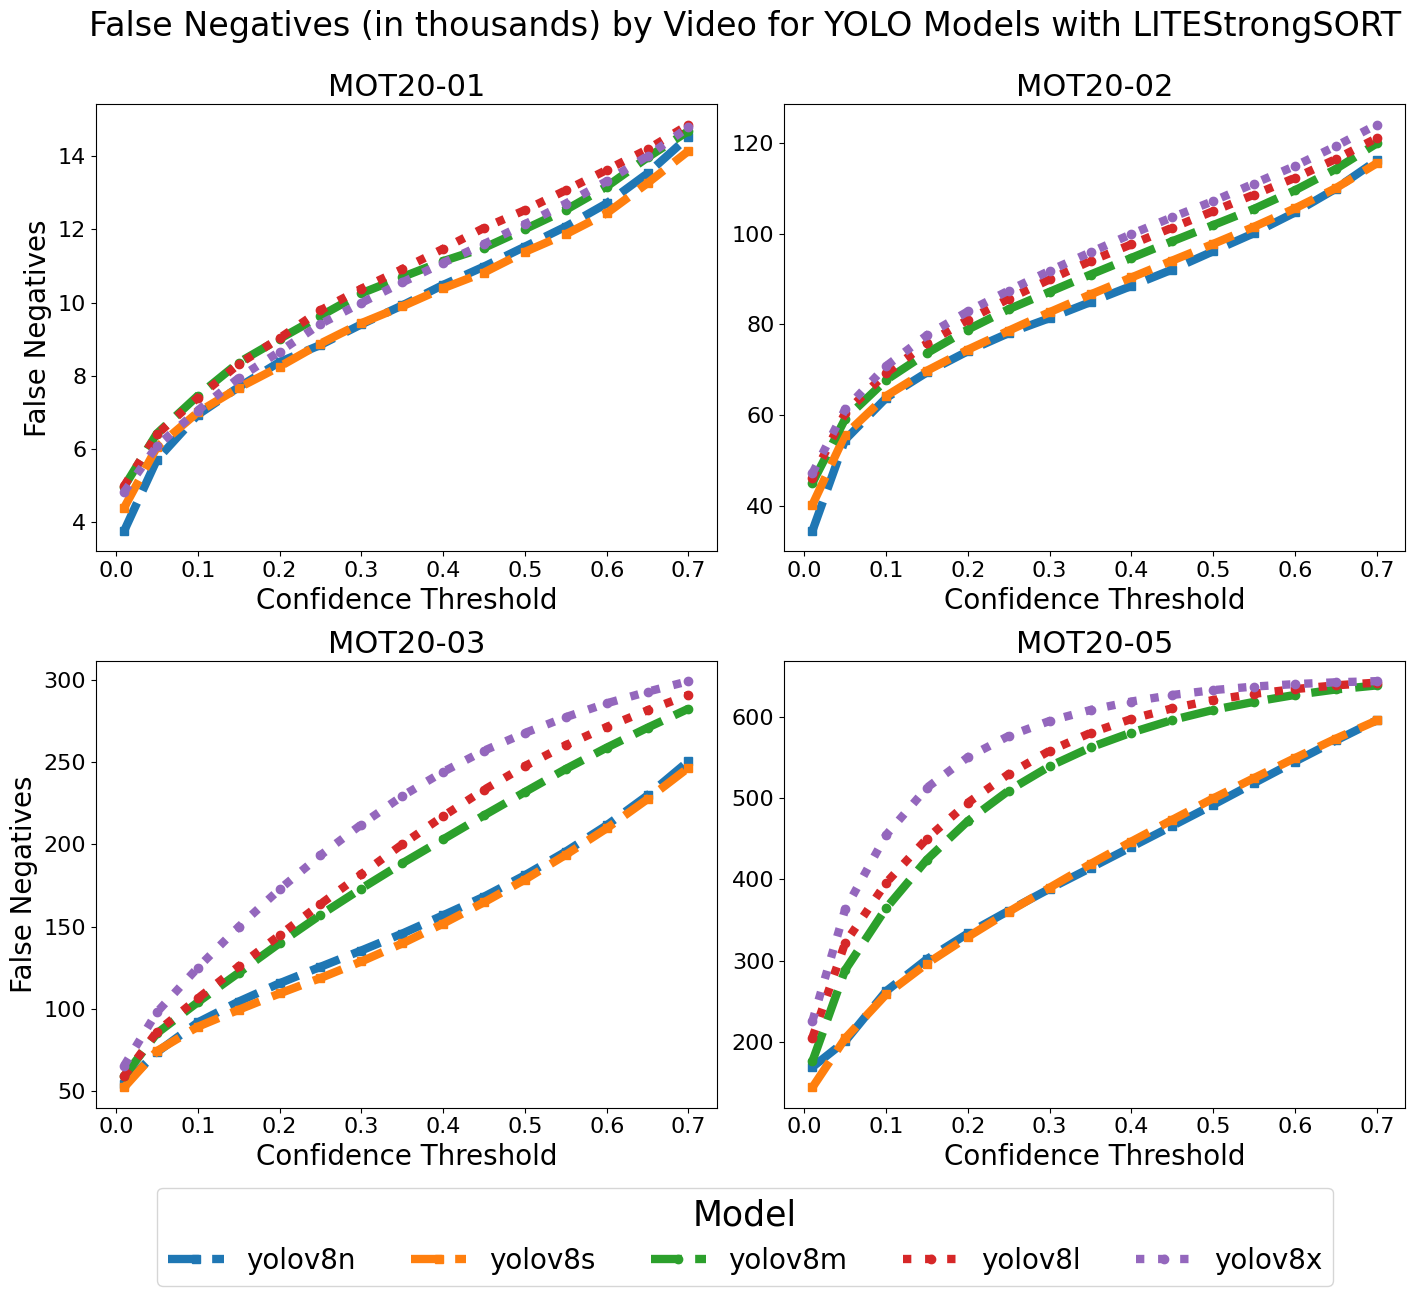

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming `all_data` is already defined with combined MOT17 and MOT20 data

# List of metrics to plot
metrics = ["clr_fn"]  # Example: plotting False Negatives
metrics_human = {"clr_fp": "False Positives", "clr_fn": "False Negatives", "clr_tp": "True Positives"}

# List of distinct trackers
trackers = ["yolov8n", "yolov8s", "yolov8m", "yolov8l", "yolov8x"]
# Assign unique markers and line styles for each tracker
markers = ['s', 's', 'o', 'o', 'o']  # Fixed set of markers
line_styles = ['--', '--', '--', ':', ':']  # Fixed set of line styles

# Create a color map for each tracker
color_map = {i: plt.cm.tab10(i) for i in range(len(trackers))}

# Generate plots for each metric
for metric in metrics:
    # Group data by video, model, and confidence threshold for the current metric
    curve_data = data_20.groupby(["video", "model", "conf"], observed=False)[metric].mean().reset_index()

    # Exclude "COMBINED" video
    curve_data = curve_data[curve_data["video"] != "COMBINED"]
    videos = curve_data["video"].unique()

    # Determine number of rows and columns for subplots
    n_videos = len(videos)
    n_cols = 2  # Number of subplots per row
    n_rows = int(np.ceil(n_videos / n_cols))

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 6 * n_rows))
    axs = axs.flatten()  # Flatten the axis array for easy indexing

    for idx, video in enumerate(videos):
        ax = axs[idx]
        video_data = curve_data[curve_data["video"] == video]
        for i, model in enumerate(video_data["model"].unique()):
            model_data = video_data[video_data["model"] == model]
            ax.plot(
                model_data["conf"].astype(float),
                model_data[metric],
                marker=markers[i],
                linestyle=line_styles[i],
                label=f"{model}",
                color=color_map[i],
                linewidth=6
            )
        # Add subplot details
        ax.set_title(f"{video}", fontsize=22)
        ax.set_xlabel("Confidence Threshold", fontsize=20)
        if idx % 2 == 0:
         ax.set_ylabel(f"{metrics_human[metric]}", fontsize=20)
        ax.tick_params(axis='both', labelsize=16)

    # Hide empty subplots
    for idx in range(len(videos), len(axs)):
        axs[idx].axis("off")

    # Create a single legend for the bottom
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(
        handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.01), ncol=5, fontsize=20, title="Model", title_fontsize=25
    )

    # Adjust layout and save
    fig.suptitle(f"{metrics_human[metric]} (in thousands) by Video for YOLO Models with LITEStrongSORT", fontsize=24)
    plt.tight_layout(rect=[0, 0.0, 0.95, 0.98])
    #plt.tight_layout()
    plt.savefig(f"{metric.lower()}_video_v8.png", dpi=600)
    plt.show()
